In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
cifar10_full = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=False, transform=transform_train)
train_size = int(0.9 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
cifar10_train, cifar10_val = random_split(cifar10_full, [train_size, val_size])

cifar10_test = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=False, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Definition of network model class
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [4]:
# load model
model = VGG11(num_classes=10).to(device)
print(model)

VGG11(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected VGGNet parameter count:", count_parameters(model))

Selected VGGNet parameter count: 28144010


In [ ]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: Train Loss: 1.9772, Val Loss: 1.7850, Val Acc: 0.2820


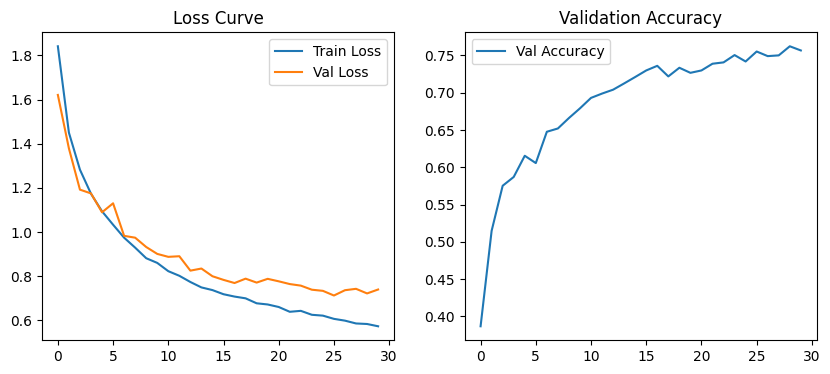

In [7]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p2_10_vggnet_results.png")
plt.show()

In [8]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [9]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar10_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.7688052365350588
Test Recall: 0.766
Test F1 Score: 0.7647815138346554

Confusion Matrix:
 [[848   7  27  16  18   2   7  13  35  27]
 [ 24 810   9   7   3  12   8   7   7 113]
 [ 55   0 674  35  69  50  69  35   5   8]
 [ 22   1  49 510  53 225  71  49   5  15]
 [ 22   2  39  33 726  51  52  70   5   0]
 [ 11   1  23 126  35 715  19  56   2  12]
 [  5   2  22  43  29  26 859   9   2   3]
 [ 13   2  21  19  23  57   5 853   0   7]
 [ 73  26  11  24   6  11   8  11 808  22]
 [ 45  37   6   9   1   9   4  17  15 857]]

Classification Report:
               precision    recall  f1-score   support

    airplane       0.76      0.85      0.80      1000
  automobile       0.91      0.81      0.86      1000
        bird       0.77      0.67      0.72      1000
         cat       0.62      0.51      0.56      1000
        deer       0.75      0.73      0.74      1000
         dog       0.62      0.71      0.66      1000
        frog       0.78      0.86      0.82      1000
   

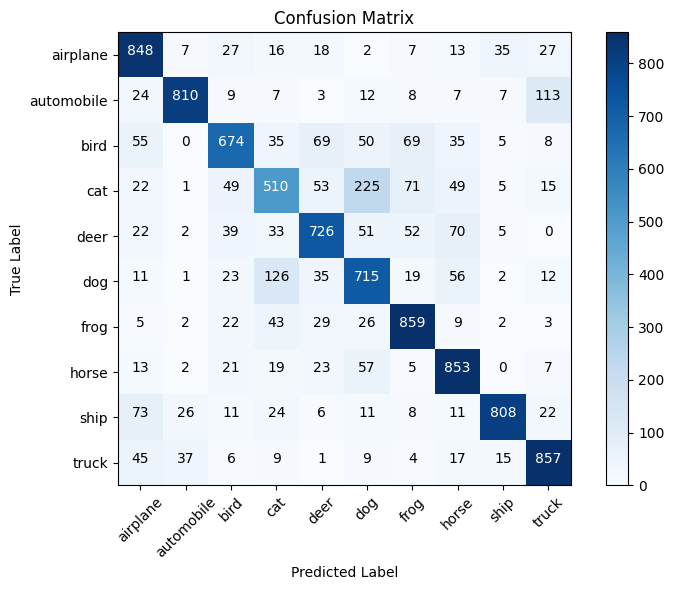

In [10]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar10_test.classes))
plt.xticks(tick_marks, cifar10_test.classes, rotation=45)
plt.yticks(tick_marks, cifar10_test.classes)

# Annotate the confusion matrix cells with the numeric values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p2_10_confusion_matrix.png")
plt.show()